<a href="https://colab.research.google.com/github/Maks3174/Phy/blob/main/exams_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'exam-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5538891%2F9166746%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240905%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240905T173549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7ecb9e8eb36c46e178852e979e9f725e848721e2cd6b8d46879e41dda6caf4cf2950d573a4b2202db62dcb08668bac605da6385b05ed49acf909c799c7aca381da58e6b2900537099c9291716a85169acfc38011c67e850e620cec53ae5d5dbaea5739fbd44aa2715df7afe402650375699e5f2ed0b2ae84b045a823f0a3e4b90e5886846550dc258d52c1073d063b14b8297723c82426f380b148965202adde82e175fea02c06f81665a7ddf66c5b64ca3ea55a8485ced5215d47b45c4a62e5bf3737de05bdafd51f93b8e873fc315904da46339afa743551218b4568123538144c977ed382c2f3c770b63da4ab2a836e3c719e54d7377f5f39ea89bf845eb1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, sqrt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import warnings

In [ ]:
warnings.filterwarnings('ignore')

# 2. Завантаження та огляд даних
# Завантаження даних
df = pd.read_csv('/kaggle/input/exam-1/data.csv')

# Виведення перших рядків для ознайомлення
print("Перші 5 рядків даних:")
print(df.head())

# Виведення інформації про DataFrame
print("\nІнформація про DataFrame:")
print(df.info())

Перші 5 рядків даних:
   Unnamed: 0  case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0           0        1              8                  c                   3   
1           1        2              2                  c                   5   
2           2        3             10                  e                   1   
3           3        4             26                  b                   2   
4           4        5             26                  b                   2   

  Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   
3                    Y                                  2  radiotherapy   
4                    Y                                  2  radiotherapy   

  Ward_Type Ward_Facility_Code  ...  patientid

In [ ]:
# 3. Попередній аналіз даних (EDA)

# 3.1 Визначення типів ознак
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nЧислові ознаки:", numeric_features)
print("Категоріальні ознаки:", categorical_features)



Числові ознаки: ['Unnamed: 0', 'case_id', 'Hospital_code', 'City_Code_Hospital', 'Available Extra Rooms in Hospital', 'Bed Grade', 'patientid', 'City_Code_Patient', 'Visitors with Patient', 'Admission_Deposit', 'doctorid', 'country_code']
Категоріальні ознаки: ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']


In [ ]:
# 3.2 Перевірка пропущених значень
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("\nПропущені значення:")
print(missing_values)


Пропущені значення:
Bed Grade               113
City_Code_Patient      4532
doctorid             316012
dtype: int64


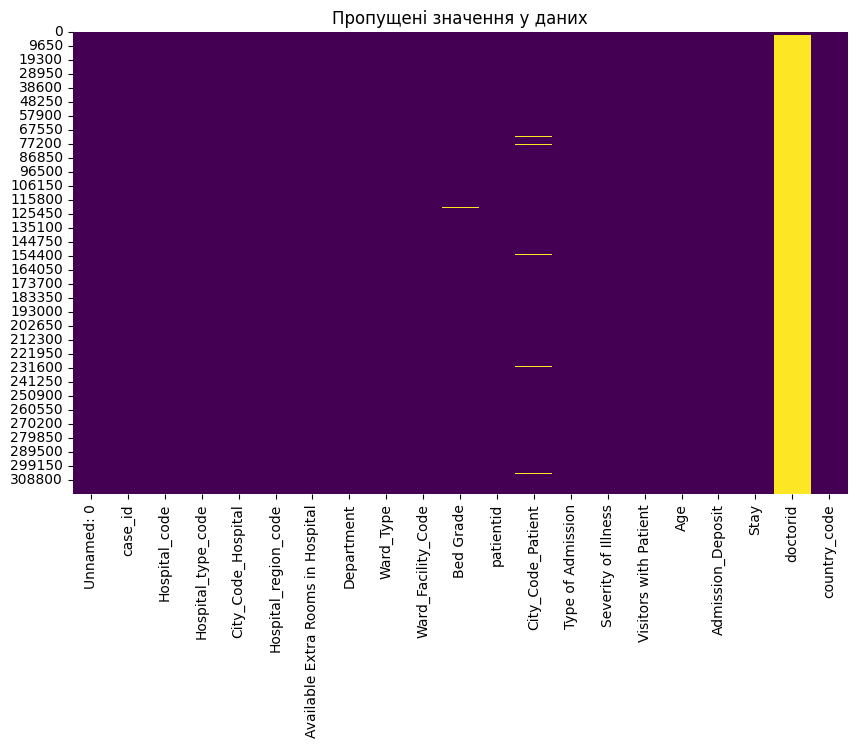

In [ ]:
# Візуалізація пропущених значень
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Пропущені значення у даних")
plt.show()

In [ ]:
# 3.3 Аналіз викидів через описову статистику
print("\nОписова статистика числових ознак:")
print(df[numeric_features].describe())


Описова статистика числових ознак:
          Unnamed: 0        case_id  Hospital_code  City_Code_Hospital  \
count  318438.000000  318438.000000  318438.000000       318438.000000   
mean   159218.500000  159219.500000      18.318841            4.771717   
std     91925.276848   91925.276848       8.633755            3.102535   
min         0.000000       1.000000       1.000000            1.000000   
25%     79609.250000   79610.250000      11.000000            2.000000   
50%    159218.500000  159219.500000      19.000000            5.000000   
75%    238827.750000  238828.750000      26.000000            7.000000   
max    318437.000000  318438.000000      32.000000           13.000000   

       Available Extra Rooms in Hospital      Bed Grade      patientid  \
count                      318438.000000  318325.000000  318438.000000   
mean                            3.197627       2.625807   65747.579472   
std                             1.168171       0.873146   37979.936440   
m

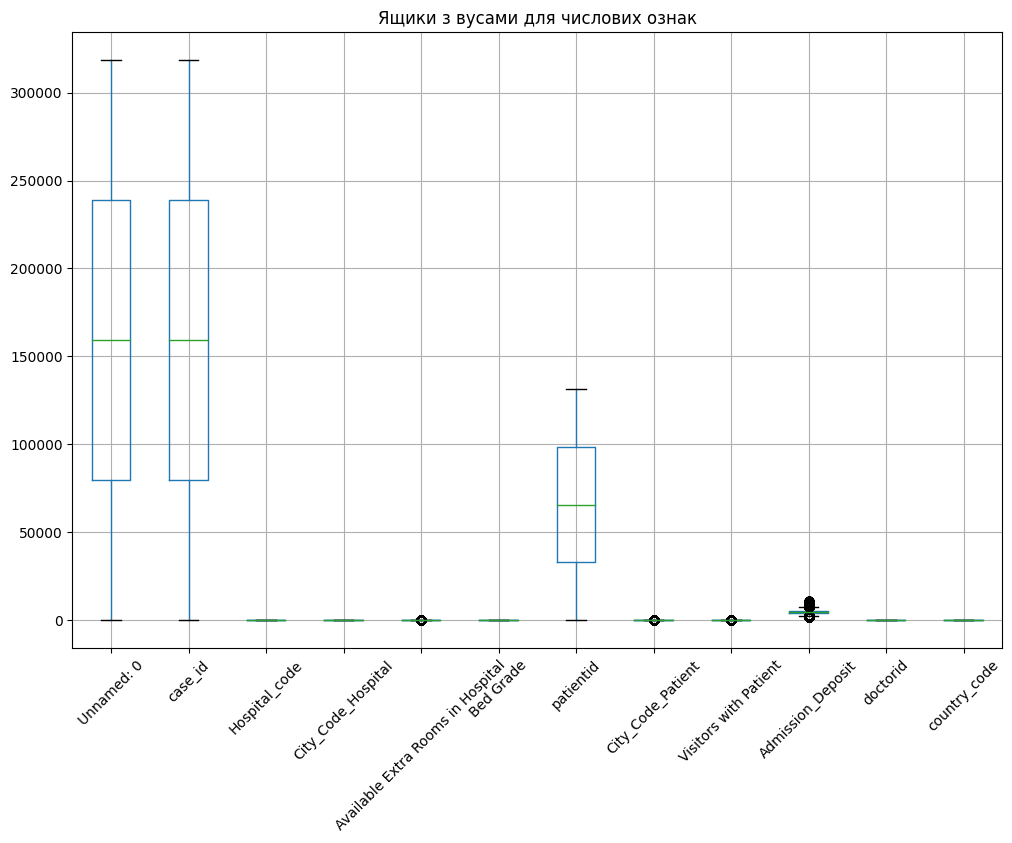

In [ ]:
# 3.4 Візуалізація викидів за допомогою ящиків з вусами
plt.figure(figsize=(12, 8))
df[numeric_features].boxplot()
plt.xticks(rotation=45)
plt.title("Ящики з вусами для числових ознак")
plt.show()

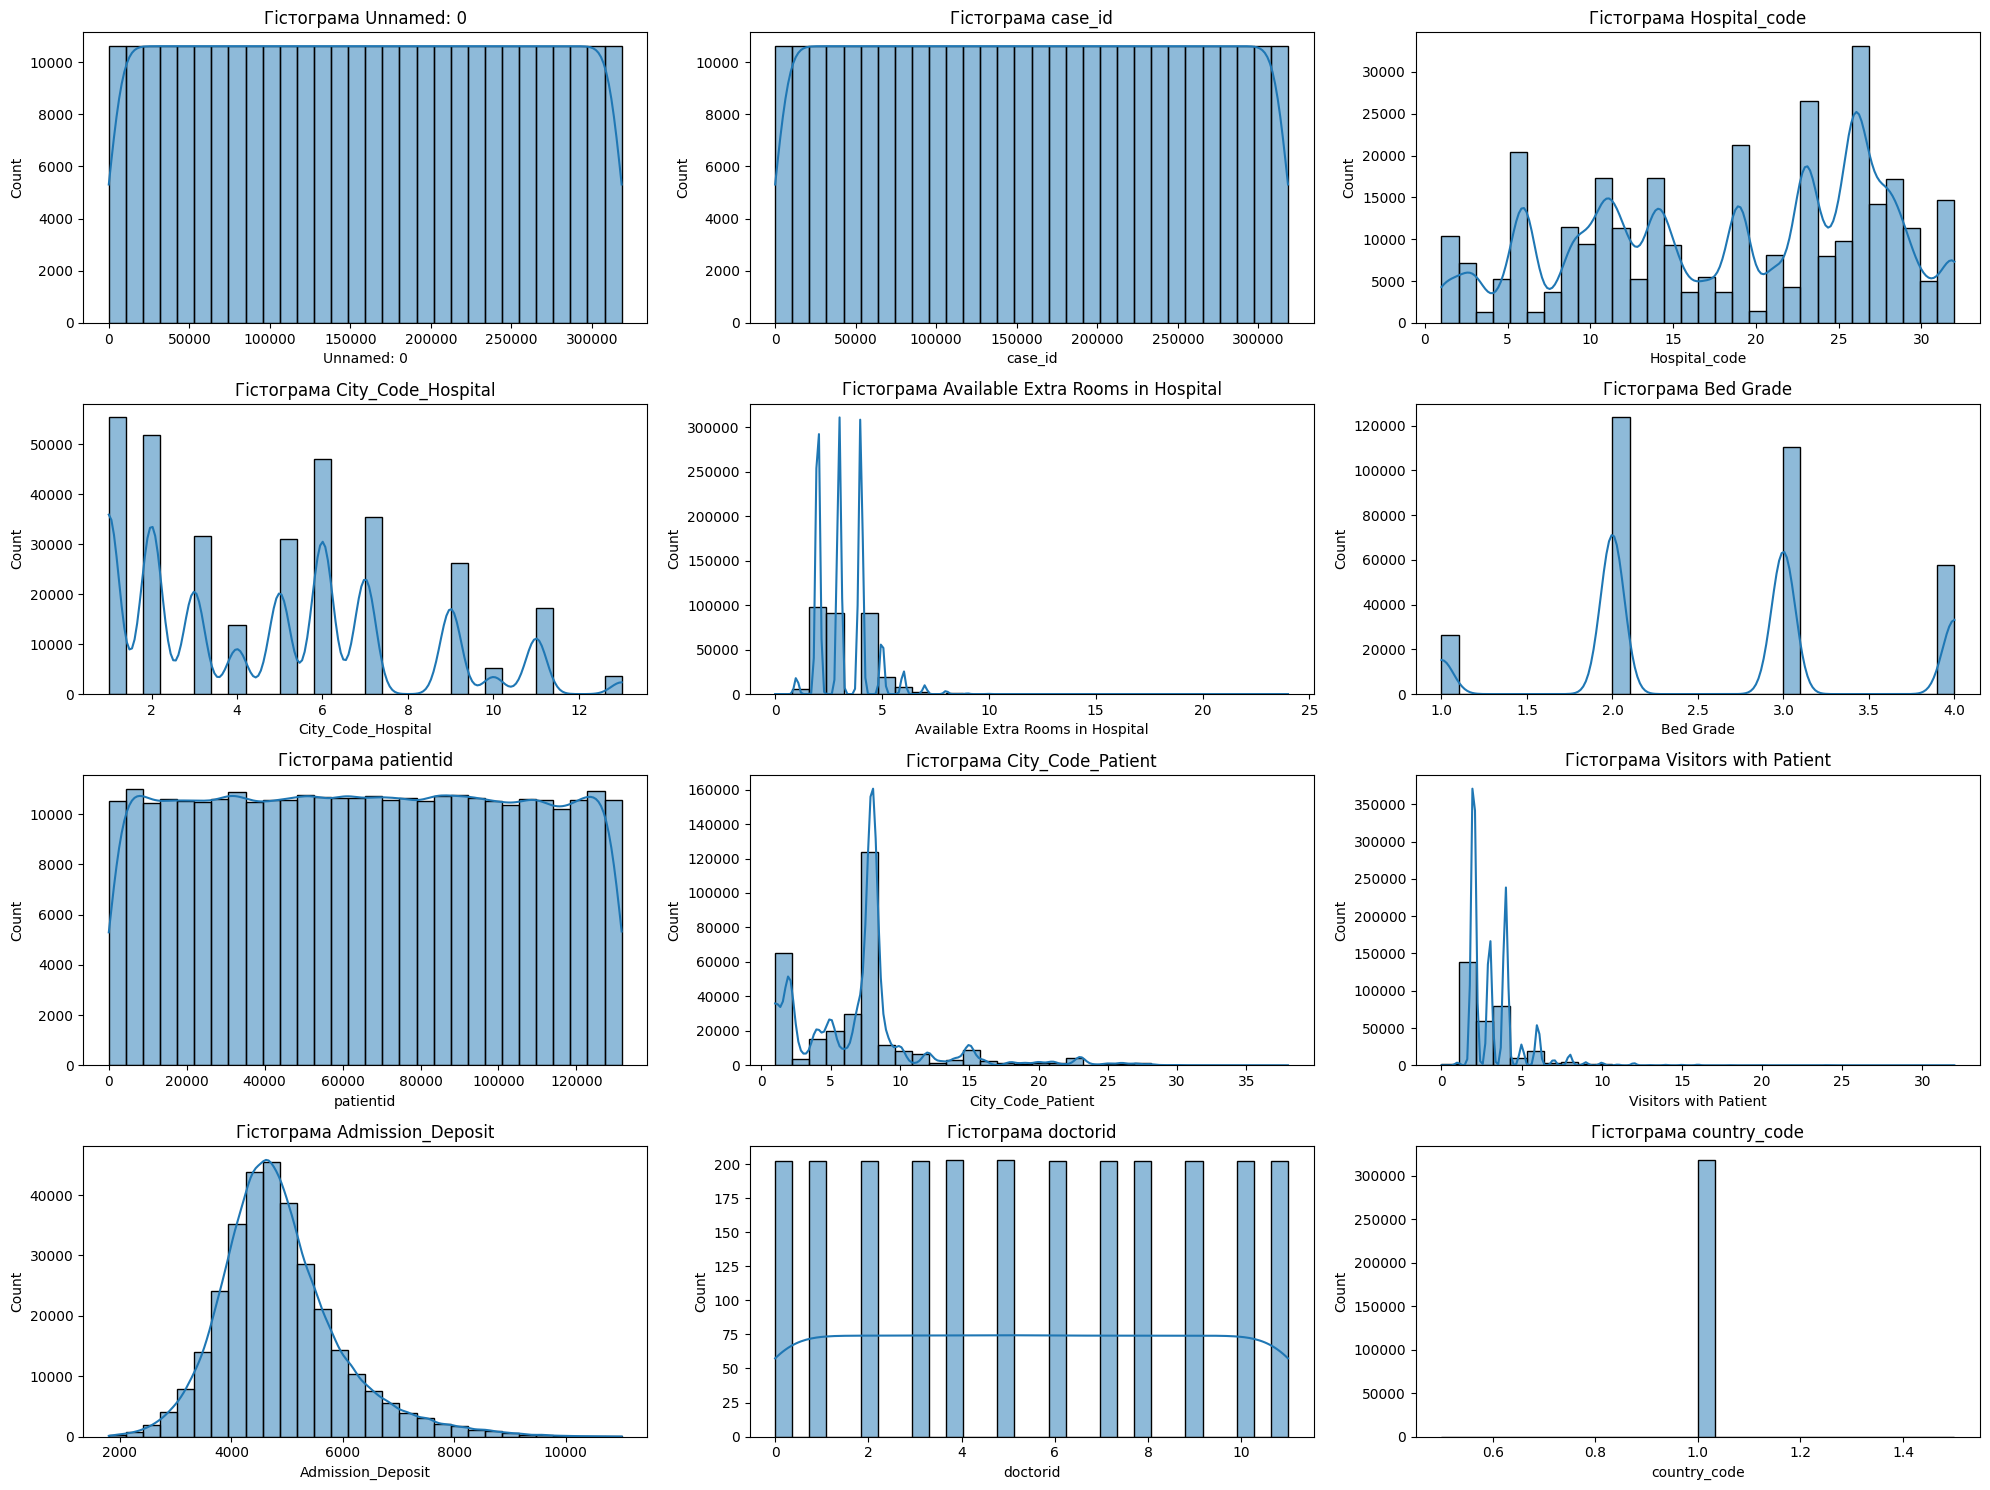

In [ ]:
# 3.5 Побудова гістограм для числових ознак
n_rows = ceil(sqrt(len(numeric_features)))
n_cols = ceil(len(numeric_features) / n_rows)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[feature].dropna(), kde=True, bins=30)
    plt.title(f'Гістограма {feature}')
plt.tight_layout()
plt.show()


Опис гістограм числових ознак:


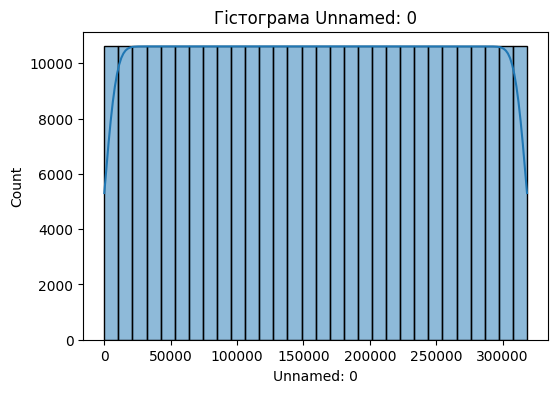

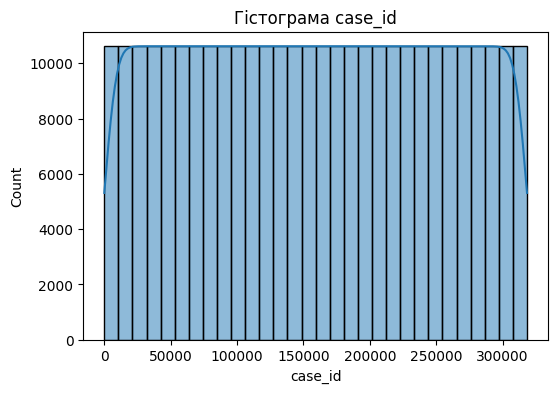

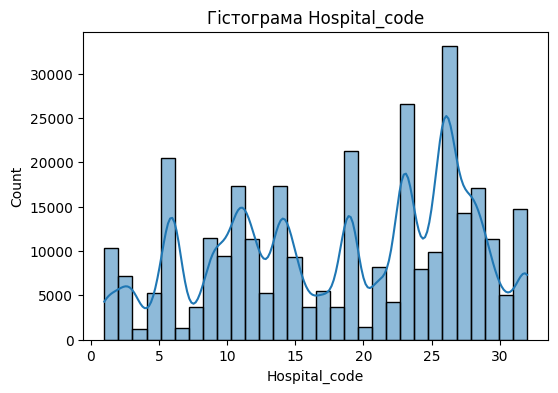

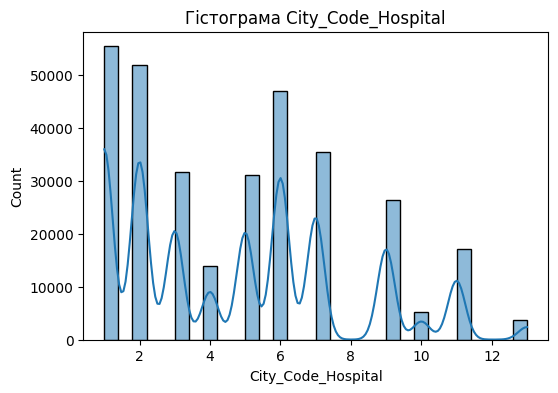

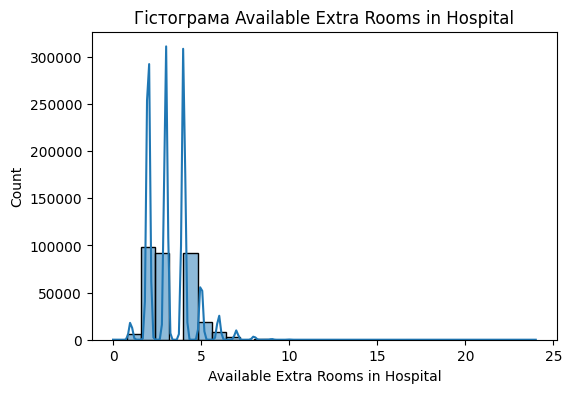

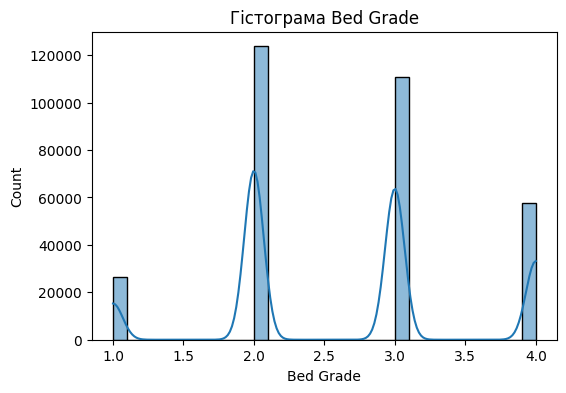

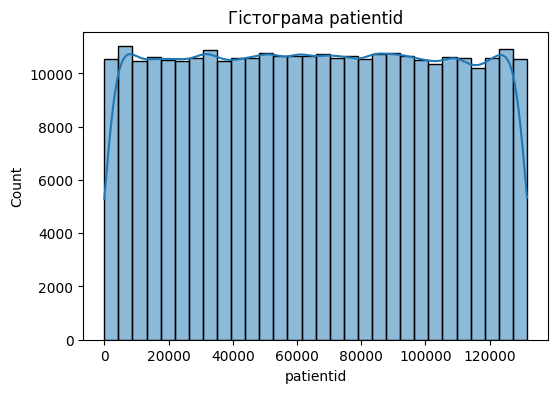

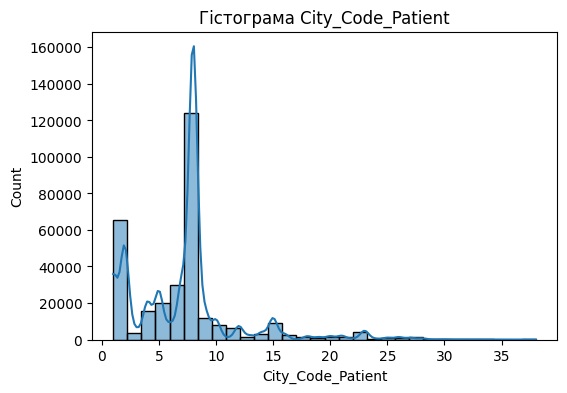

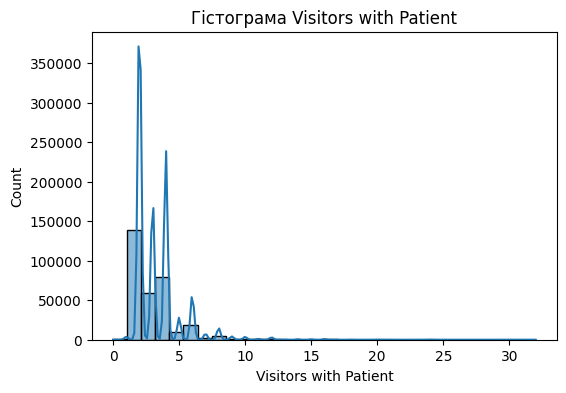

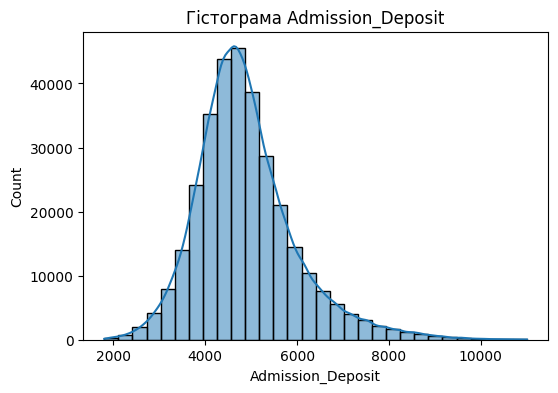

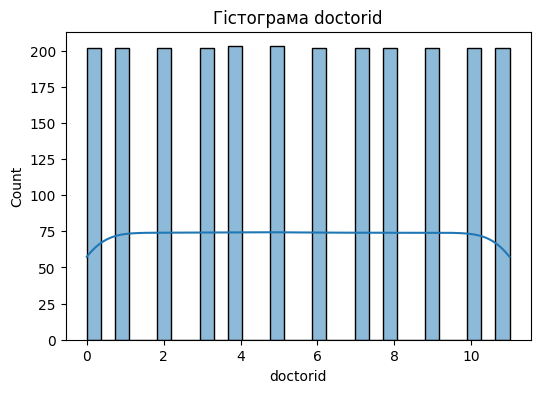

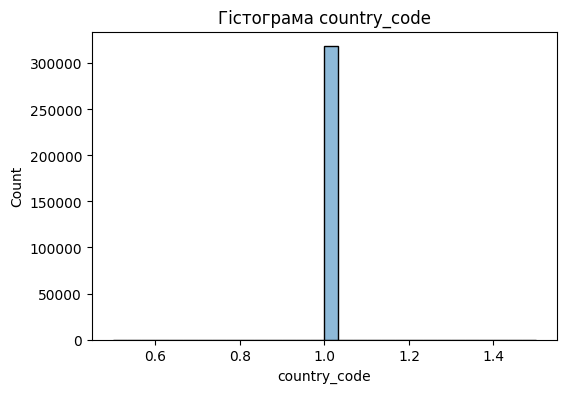

In [ ]:
# Опис гістограм
print("\nОпис гістограм числових ознак:")
for feature in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[feature].dropna(), kde=True, bins=30)
    plt.title(f'Гістограма {feature}')
    plt.show()

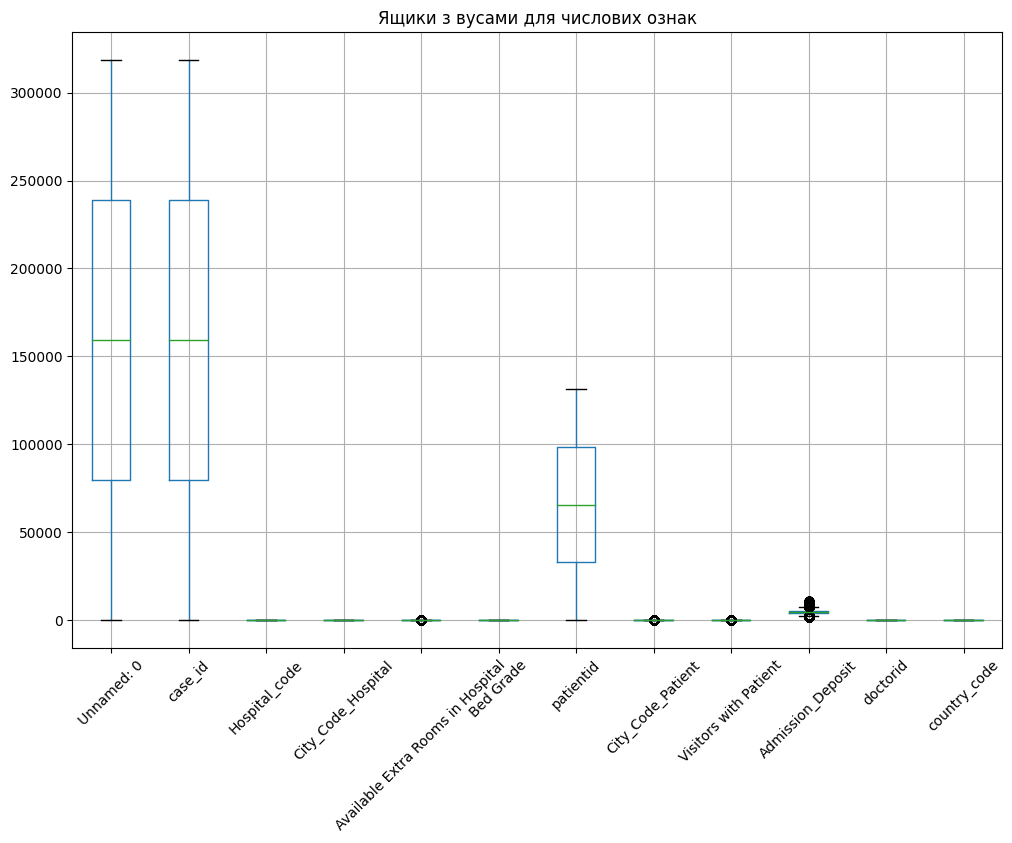

In [ ]:

# 3.6 Ящики з вусами для числових ознак
plt.figure(figsize=(12, 8))
df[numeric_features].boxplot()
plt.xticks(rotation=45)
plt.title("Ящики з вусами для числових ознак")
plt.show()


Опис ящиків з вусами числових ознак:


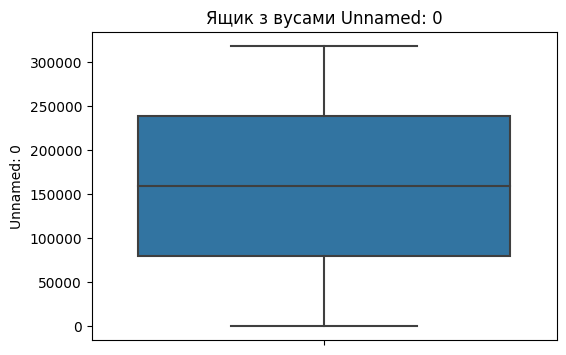

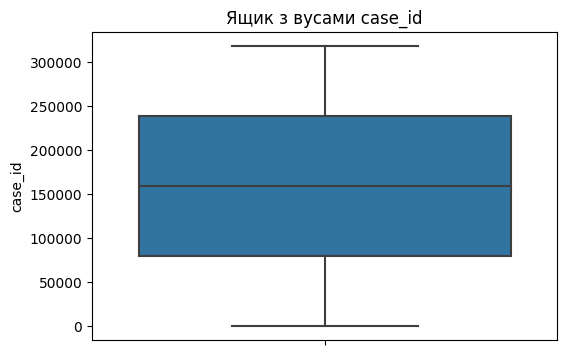

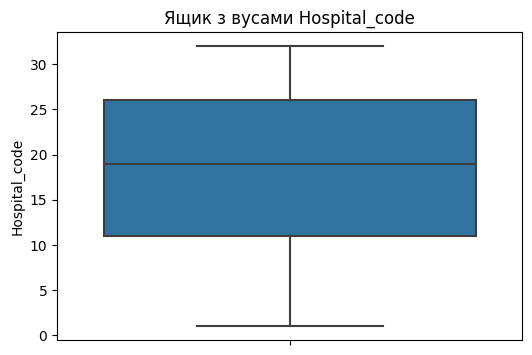

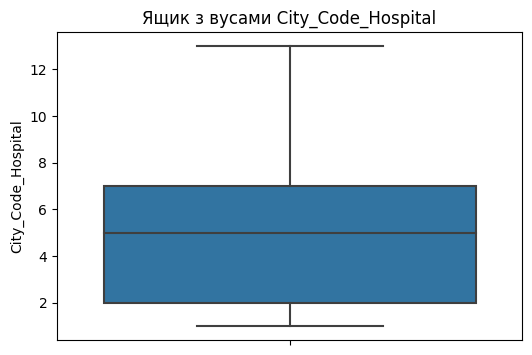

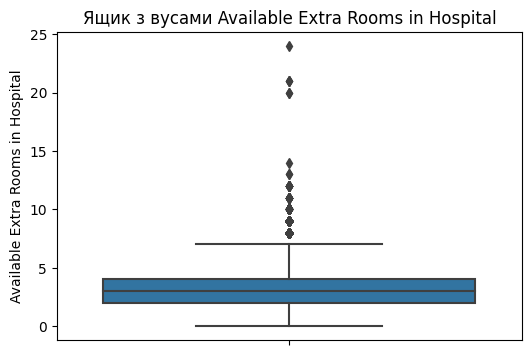

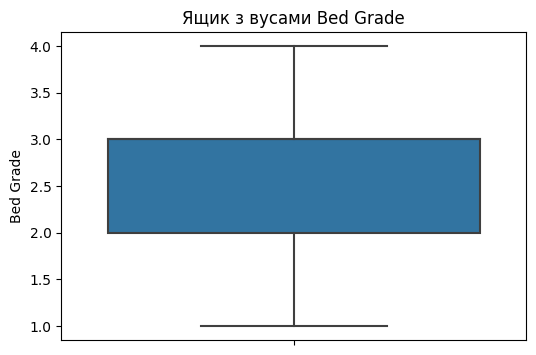

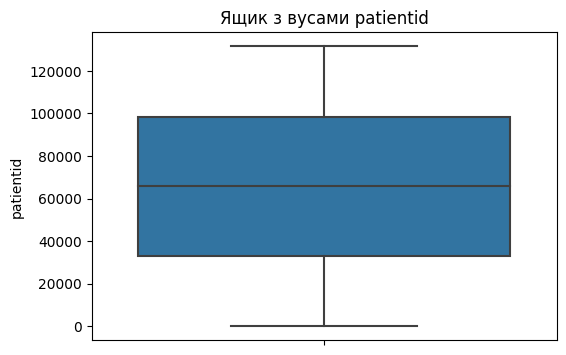

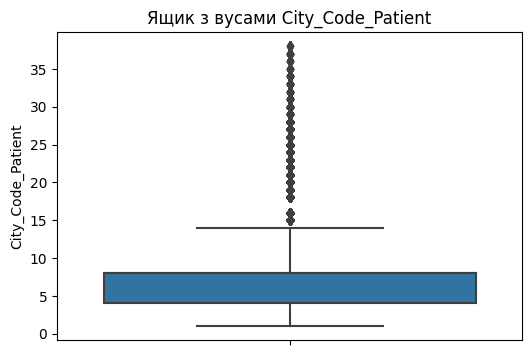

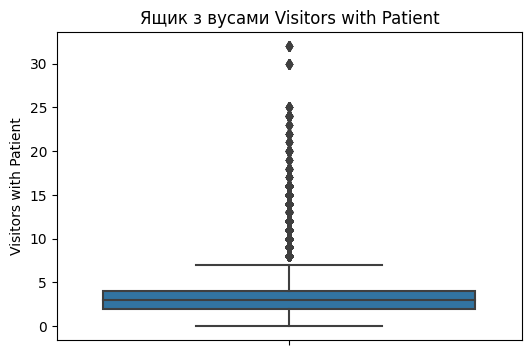

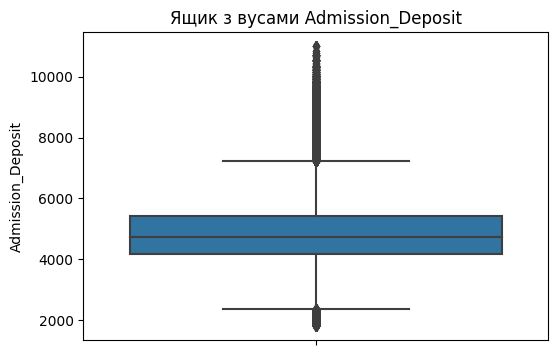

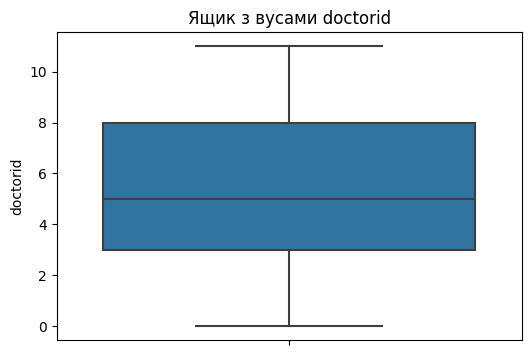

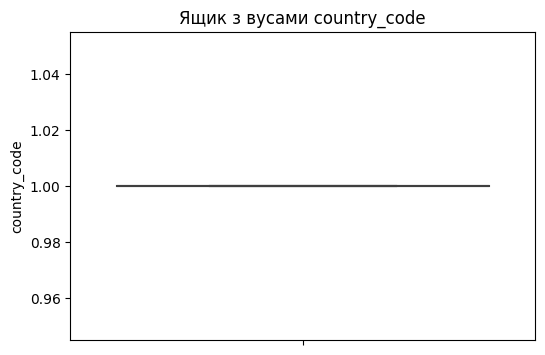

In [ ]:
# Опис ящиків
print("\nОпис ящиків з вусами числових ознак:")
for feature in numeric_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[feature])
    plt.title(f'Ящик з вусами {feature}')
    plt.show()

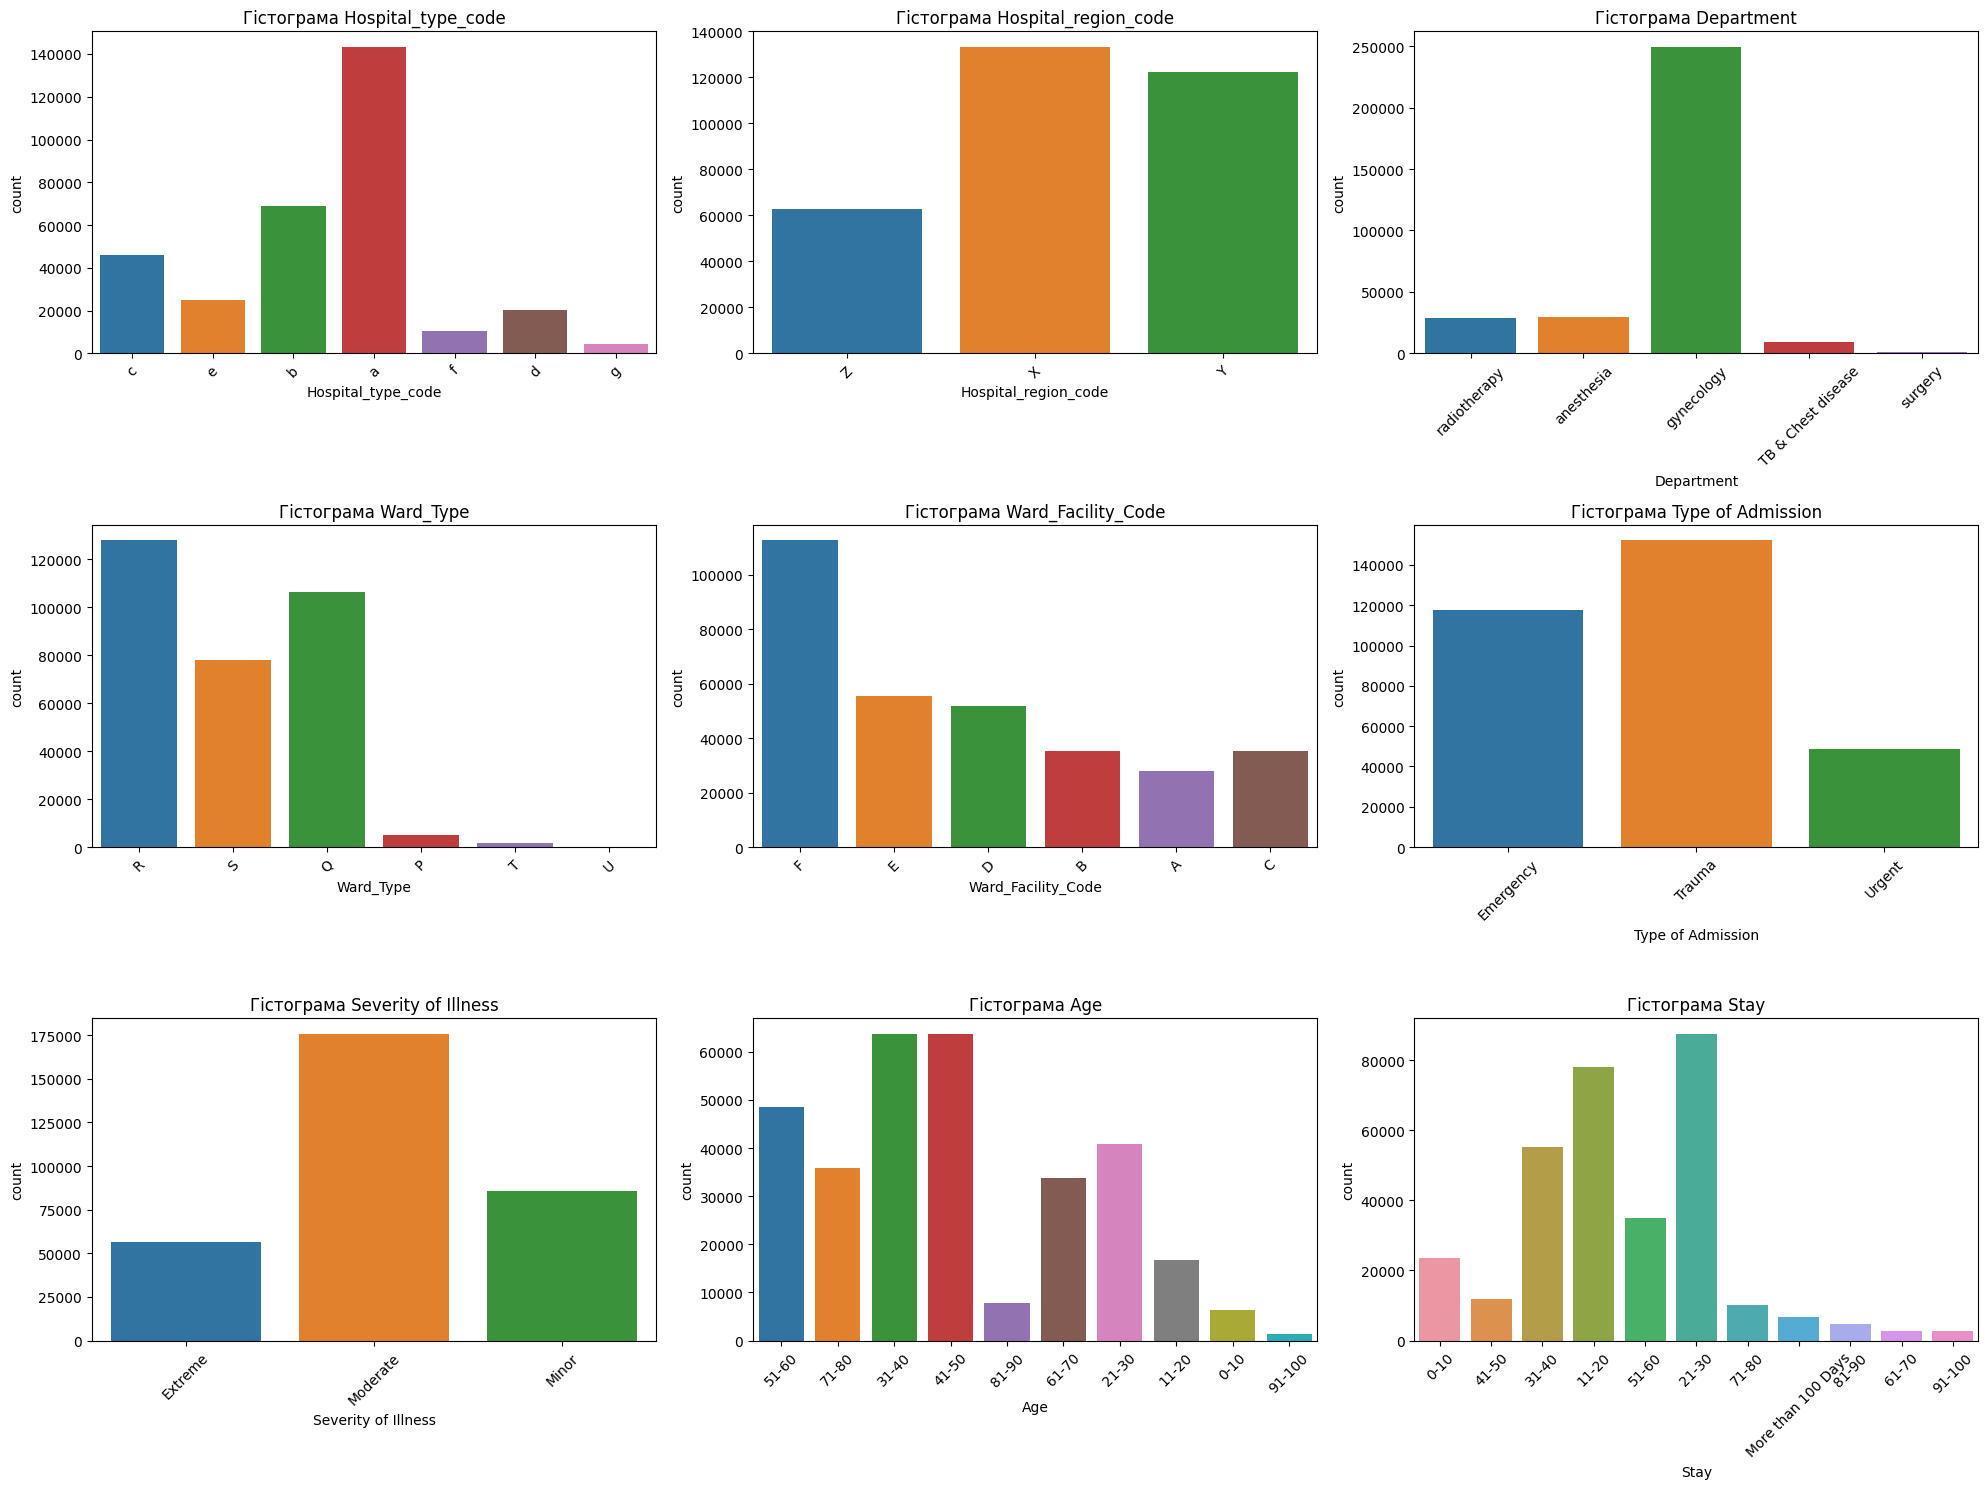

In [ ]:
# 3.7 Гістограми для категоріальних ознак
n_rows_cat = ceil(sqrt(len(categorical_features)))
n_cols_cat = ceil(len(categorical_features) / n_rows_cat)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features):
    plt.subplot(n_rows_cat, n_cols_cat, i+1)
    sns.countplot(x=df[feature])
    plt.title(f'Гістограма {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

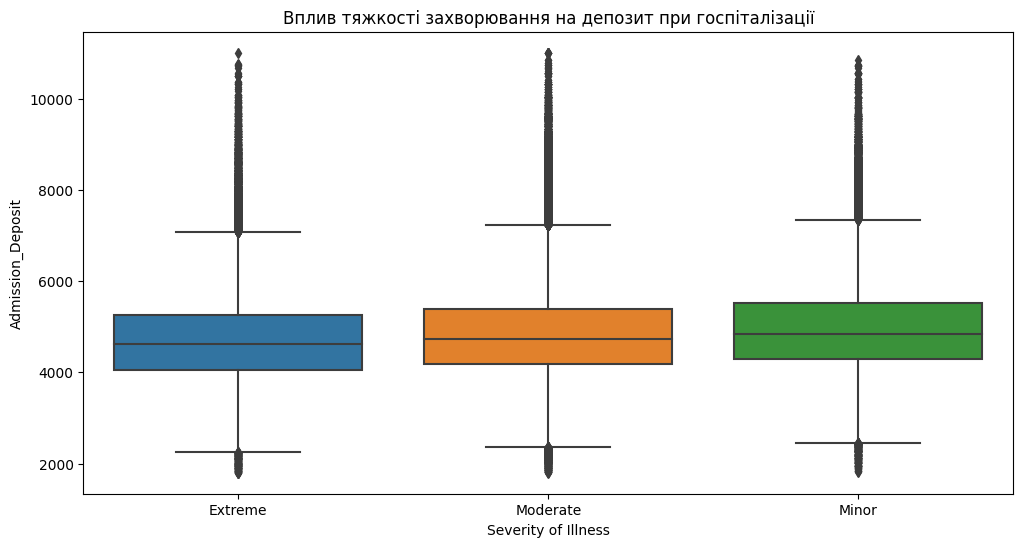

In [ ]:
# 3.8 Групові ящики з вусами для числової та категоріальної ознаки
plt.figure(figsize=(12, 6))
sns.boxplot(x='Severity of Illness', y='Admission_Deposit', data=df)
plt.title("Вплив тяжкості захворювання на депозит при госпіталізації")
plt.show()

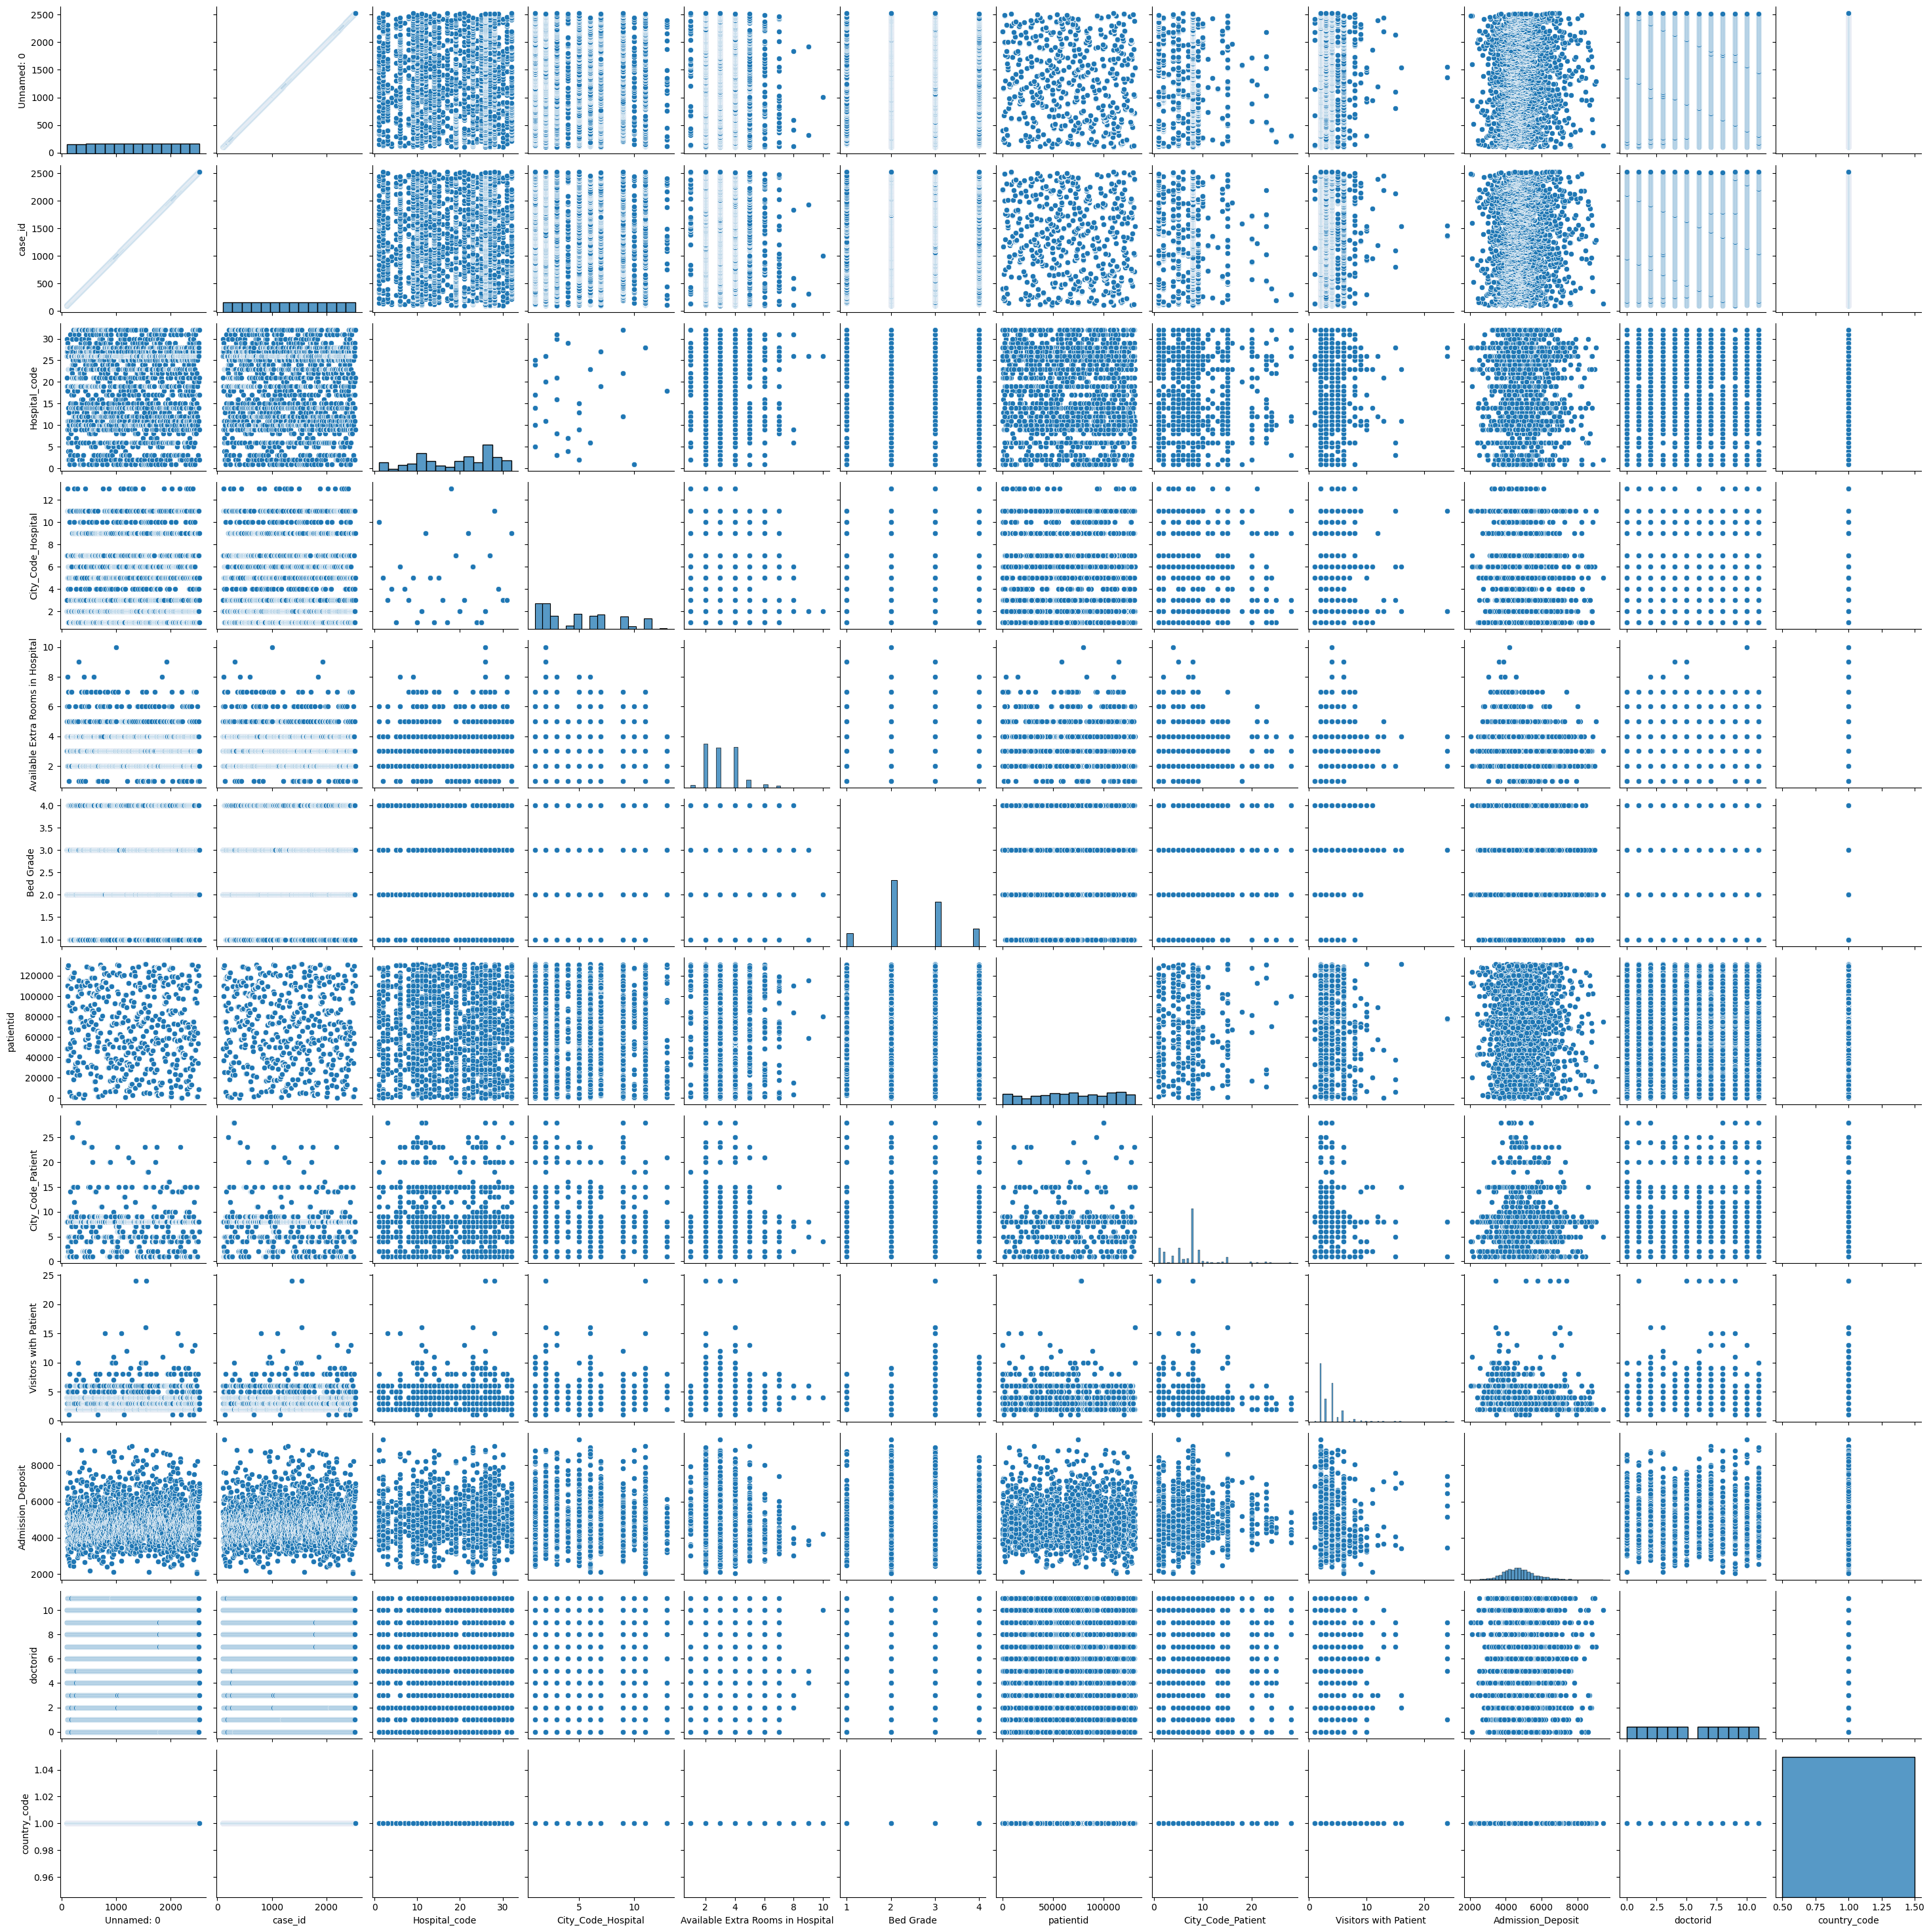

In [ ]:
# 3.9 Точкові діаграми (Pairplot) для числових ознак
sns.pairplot(df[numeric_features].dropna())
plt.show()

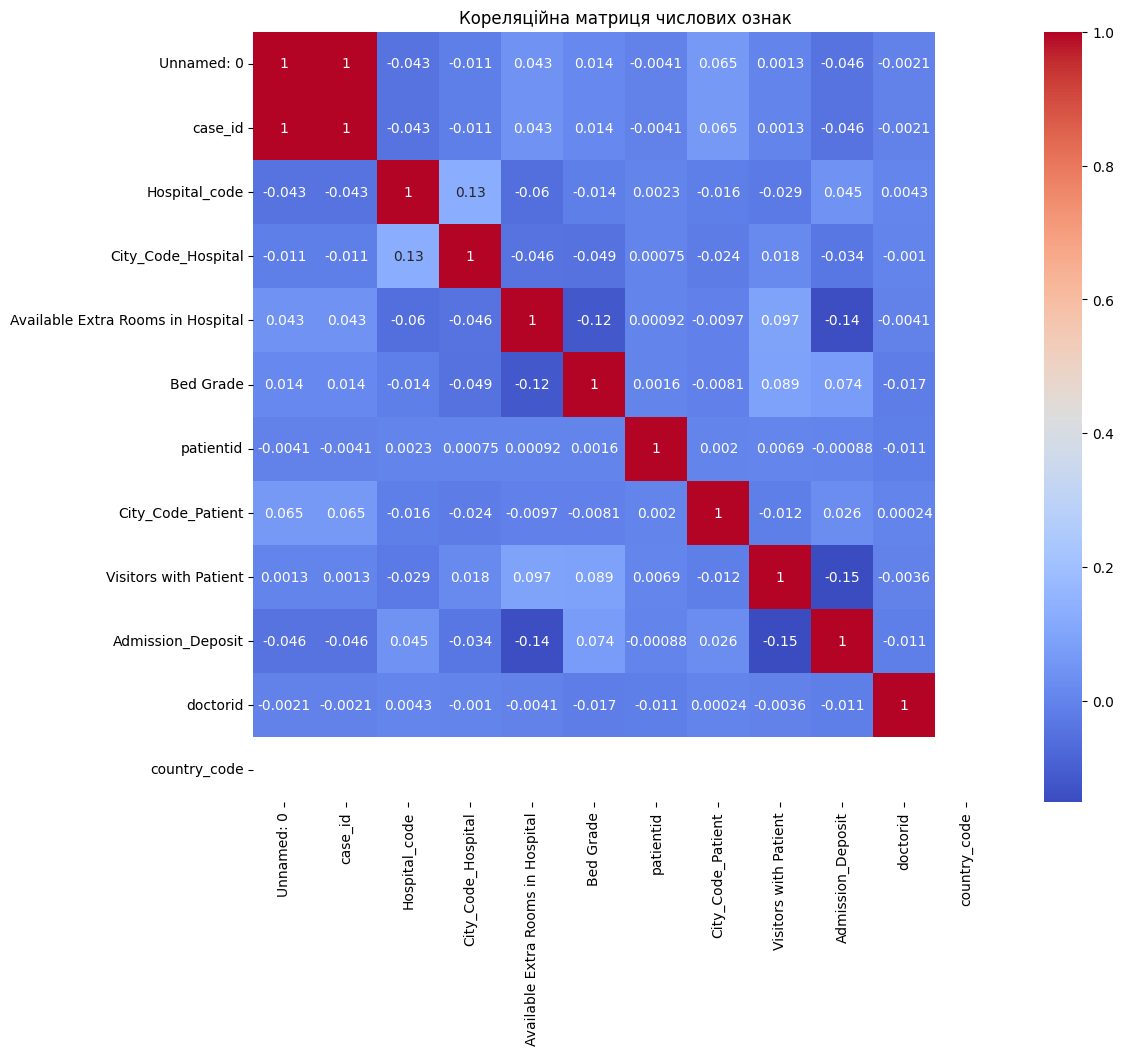

In [ ]:
# Визначення залежностей між числовими ознаками
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Кореляційна матриця числових ознак")
plt.show()

In [ ]:
# 4. Підготовка даних

# 4.1 Обробка пропущених значен
df_clean = df.dropna()
print(f"\nКількість рядків після видалення пропущених значень: {df_clean.shape[0]}")


Кількість рядків після видалення пропущених значень: 2411


In [ ]:
# 4.2 Перетворення категоріальних ознак на числові за допомогою LabelEncoder
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df_clean[feature] = le.fit_transform(df_clean[feature])
    label_encoders[feature] = le

In [ ]:
# 4.3 Створення цільових змінних

# Для класифікації можемо створити діапазони днів
max_stay = df_clean['Stay'].max()

# Якщо максимальне значення менше або дорівнює 15, змінюємо верхню межу
if max_stay <= 15:
    max_stay = 16

# Створюємо бінс
df_clean['Stay_Range'] = pd.cut(df_clean['Stay'], bins=[0, 5, 10, 15, max_stay], labels=[0, 1, 2, 3])

In [ ]:
# Визначення ознак і цільових змінних
X = df_clean.drop(columns=['Stay', 'Stay_Range', 'Stay_Days'] if 'Stay_Days' in df_clean.columns else ['Stay', 'Stay_Range'])
y_regression = df_clean['Stay']
y_classification = df_clean['Stay_Range']

In [ ]:
# 4.4 Розділення даних на тренувальні та тестові набори
# Для регресії
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
# Для класифікації
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42)

In [ ]:
# 4.5 Стандартизація числових ознак
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

In [ ]:
# 5. Побудова та оцінка моделей

# 5.1 Регресія
print("\n--- Регресія ---")
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_reg, y_train_reg)
y_pred_reg = regressor.predict(X_test_reg)


--- Регресія ---


In [ ]:
# Оцінка моделі регресії
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 2.556212215320911
R^2 Score: 0.555665357636757


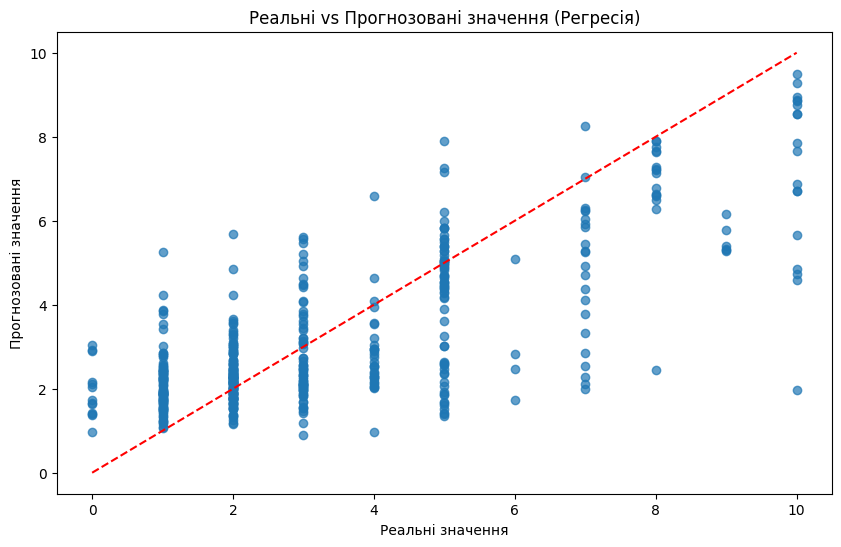

In [ ]:
# Візуалізація реальних vs прогнозованих значень
plt.figure(figsize=(10,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.7)
plt.xlabel("Реальні значення")
plt.ylabel("Прогнозовані значення")
plt.title("Реальні vs Прогнозовані значення (Регресія)")
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.show()

In [ ]:
# 5.2 Класифікація
# Перевірка наявності NaN у цільовій змінній
print(y_train_class.isna().sum())
print(y_test_class.isna().sum())

# Якщо є пропущені значення, їх потрібно видалити або замінити
# Наприклад, можна видалити рядки з NaN значеннями:
X_train_class = X_train_class[~y_train_class.isna()]
y_train_class = y_train_class.dropna()

X_test_class = X_test_class[~y_test_class.isna()]
y_test_class = y_test_class.dropna()

98
13


In [ ]:
# Навчання моделі
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_class, y_train_class)

# Прогнозування
y_pred_class = classifier.predict(X_test_class)

# Оцінка моделі класифікації
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       404
           1       0.91      0.30      0.45        66

    accuracy                           0.90       470
   macro avg       0.90      0.65      0.70       470
weighted avg       0.90      0.90      0.87       470

Accuracy: 0.8978723404255319


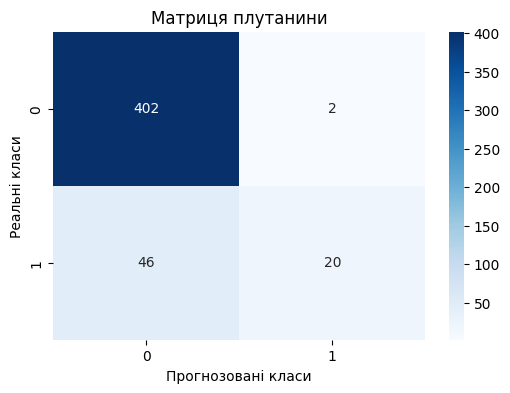

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Прогнозовані класи')
plt.ylabel('Реальні класи')
plt.title("Матриця плутанини")
plt.show()

In [ ]:
# 6. Підбір гіперпараметрів

# 6.1 Підбір для регресії
print("\n--- Підбір гіперпараметрів для регресії ---")
param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_reg = GridSearchCV(estimator=regressor, param_grid=param_grid_reg, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_reg.fit(X_train_reg, y_train_reg)

print("Найкращі параметри для регресії:", grid_search_reg.best_params_)
print(f"Найкращий MSE для регресії: {-grid_search_reg.best_score_}")


--- Підбір гіперпараметрів для регресії ---
Найкращі параметри для регресії: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Найкращий MSE для регресії: 2.501222198450209


In [ ]:
# 6.2 Підбір для класифікації
print("\n--- Підбір гіперпараметрів для класифікації ---")
param_grid_class = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_class = GridSearchCV(estimator=classifier, param_grid=param_grid_class, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_class.fit(X_train_class, y_train_class)

print("Найкращі параметри для класифікації:", grid_search_class.best_params_)
print(f"Найкраща точність для класифікації: {grid_search_class.best_score_}")


--- Підбір гіперпараметрів для класифікації ---
Найкращі параметри для класифікації: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Найкраща точність для класифікації: 0.9032786885245901


In [ ]:
# 7. Збереження моделей
joblib.dump(regressor, 'regression_model.pkl')
joblib.dump(classifier, 'classification_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("\nМоделі збережено у файли 'regression_model.pkl' та 'classification_model.pkl'.")


Моделі збережено у файли 'regression_model.pkl' та 'classification_model.pkl'.
